# Value iteration

The goal of today's tutorial is to implement the **Value Iteration** algorithm in a simple grid world. 


In [2]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# to do movies
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

## The environment

We create the class **GridWorld**, which a $N \times N$ grid with a starting cell at the coordinate $[0, 0]$ and

- hole cells that terminate the episode with a punishment
- obstacle cells that cannot be entered
- goal cells that terminate the episode with a reward

There are four possible actions at each grid cell (down, up, right, left) that correspond to the integers between 0 and 3. 

Entering a grid cell gives a reward (possibly negative): 

- normal grid cells give -1
- holes give -10
- goals give +10

Three matrices are created as variables of the class *GridWorld*:

- **map** is used to represent the different cell types graphically
    - -1: holes (r = - 10, terminal state)
    - 0: start state
    - 1: normal grid cell (r = -1)
    - 2: obstacles (not reachable)
    - 3: goal (r = 10, terminal state)
- **rewards** is used to store the rewards gained when entering a cell
- **terminal** is a boolean matrix with True on terminal states (goals or holes) and False otherwise

In [3]:
class GridWorld():
    def __init__(self, N, goals=[], holes=[], obstables=[]):
        # scalar variables
        self.N = N
        self.Nstates = N**2
        self.Nactions = 4

        # matrices
        self.map = np.ones((N, N), dtype=int)
        self.rewards = -np.ones((N, N), dtype=int)
        self.terminal = np.zeros((N, N), dtype=bool)
        
        # adding particular cells in matrices
        self._add_start()
        self._add_goals(goals)
        self._add_holes(holes)
        self._add_obstacles(obstables)
        
        # calculating the transition matrix 
        self._calculate_transition_matrix()
        
        # placing the agent in the start state
        self.reset()
        
    def reset(self):
        self.agent = [0, 0]
        self.agentarchive = [self.agent]        
        
    def step(self, a):
        # move the agent according to the transition matrix
        s = self._coord_to_state(self.agent)
        s_ = self.transition_matrix[s, a]
        self.agent = self._state_to_coord(s_)
        self.agentarchive.append(self.agent)
        
        # calculate the reward and determines if a terminal state has been reached
        coord_ = tuple(self.agent)
        r = self.rewards[coord_]
        if self.terminal[coord_]:
            done = True
        else:
            done = False
        return s_, r, done
    
    def get_current_state(self):
        return self._coord_to_state(self.agent)
    
    def get_coord(self, s):
        return self._state_to_coord(s)

    def get_reward(self, s):
        return self.rewards[tuple(self._state_to_coord(s))]

    def get_terminal(self, s):
        return self.terminal[tuple(self._state_to_coord(s))]     
    
    #__ internal functions _____________________
    def _coord_to_state(self, coord):
        row = coord[0]
        col = coord[1]
        return row * self.N + col
        
    def _state_to_coord(self, state):
        row = state // self.N
        col = state %  self.N
        return [row, col]
    
    def _add_start(self):
        self.map[0, 0] = 0
    
    def _add_goals(self, goals):
        for goal in goals:
            self.map[tuple(goal)] = 3
            self.rewards[tuple(goal)] = 10
            self.terminal[tuple(goal)] = True
            
    def _add_holes(self, holes):
        for hole in holes:
            self.map[tuple(hole)] = -1
            self.rewards[tuple(hole)] = -10
            self.terminal[tuple(hole)] = True
            
    def _add_obstacles(self, obstacles):
        for obstacle in obstacles:
            self.map[tuple(obstacle)] = 2
            
    #__ transition matrix: s_ = T(s,a) _____________________            
    def _calculate_transition_matrix(self):
        T = np.zeros((self.Nstates, self.Nactions), dtype=int)
        for s in range(self.Nstates):
            coord = self._state_to_coord(s)
            row = coord[0]
            col = coord[1]
            
            # a = 0 (DOWN)
            row0 = min(row + 1, self.N - 1)
            if self.map[row0, col] == 2:
                T[s,0] = s
            else:
                T[s,0] = self._coord_to_state([row0, col])
 
            # a = 1 (UP)
            row1 = max(row - 1, 0)
            if self.map[row1, col] == 2:
                T[s,1] = s
            else:
                T[s,1] = self._coord_to_state([row1, col])

            # a = 2 (RIGHT)
            col2 = min(col + 1, self.N - 1)
            if self.map[row, col2] == 2:
                T[s,2] = s
            else:
                T[s,2] = self._coord_to_state([row, col2])
            
            # a = 3 (LEFT)
            col3 = max(col - 1, 0)
            if self.map[row, col3] == 2:
                T[s,3] = s
            else:
                T[s,3] = self._coord_to_state([row, col3])
            
        self.transition_matrix = T      
        
    #__ rendering functions _____________________
    def render(self):
        self._init_render()
        self.anim = matplotlib.animation.FuncAnimation(
            self.fig, 
            self._animate,
            frames=len(self.agentarchive),
            interval=500,
        )
        plt.show()
        
    def _init_render(self):
        self.fig, self.ax = plt.subplots(1,1)
        self.ax.imshow(self.map, cmap='gist_earth')
        self.agentdata, = self.ax.plot(0, 0,'or')
        
        self.ax.grid(False)
        self.ax.set_xlabel('columns')
        self.ax.set_ylabel('rows')
        plt.ioff()
    
    def _animate(self,i):
        self.agentdata.set_data(self.agentarchive[i][1], self.agentarchive[i][0])
        self.ax.set_title('time: %3d' % i)


Here is an example of the usage of the class *GridWorld*.

First an instance of the class is created, by passing as arguments:
- the size *N* of the grid world 
- the list of goals (a list of [row, col]-coordinates)
- the list of holes
- the list of obstacles

The grid can be rendered using the function **render()**. 

<IPython.core.display.Javascript object>


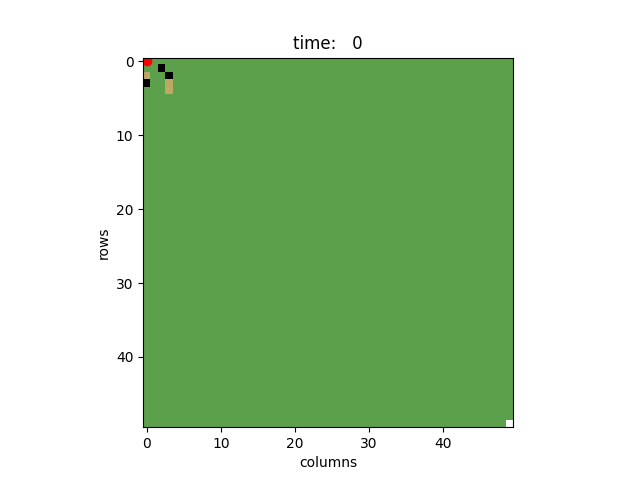

In [35]:
# PARAMETERS
N = 50
GOALS = [
    [49, 49]
]
HOLES = [
    [3, 0],
    [2, 3],
    [1, 2],    
]
OBSTACLES = [
    [2, 0],
    [3, 3],    
    [4, 3],    
]

# Creation of the grid and rendering
mygrid = GridWorld(N, goals=GOALS, holes=HOLES, obstables=OBSTACLES)
mygrid.render()

We can now use the function **step(action)** to move an agent randomly on the grid. 

Here, state is an integer between 0 (the starting state) and $N^2$. 

The function **step(action)** returns the new state, the reward received, and a boolean indicating if the episode is finished. 

s:   0  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 2  |  r:  -1  |  s_:   6
s:   6  |  a: 1  |  r:  -1  |  s_:   1
s:   1  |  a: 2  |  r:  -1  |  s_:   2
s:   2  |  a: 3  |  r:  -1  |  s_:   1
s:   1  |  a: 1  |  r:  -1  |  s_:   1
s:   1  |  a: 2  |  r:  -1  |  s_:   2
s:   2  |  a: 3  |  r:  -1  |  s_:   1
s:   1  |  a: 3  |  r:  -1  |  s_:   0
s:   0  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 1  |  r:  -1  |  s_:   0
s:   0  |  a: 1  |  r:  -1  |  s_:   0
s:   0  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 1  |  r:  -1  |  s_:   0
s:   0  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 3  |  r:  -1  |  s_:   5
s:   5  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 3  |  r:  -1  |  s_:   5
s:   5  |  a: 3  |  r:  -1  |  s_:   5
s:   5  |  a: 1  |  r:  -1  |  s_:   0
s:   0  |  a: 3  |  r:  -1  |  s_:   0
s:   0  |  a: 1  |  r:  -1  |  s_:   0
s:   0  |  a: 2  |  r:  -1  |  s_:   1
s:   1  |  a: 3  |  r:  -1  |  s_:   0
s:   0  |  a: 1  |  r:  -

<IPython.core.display.Javascript object>


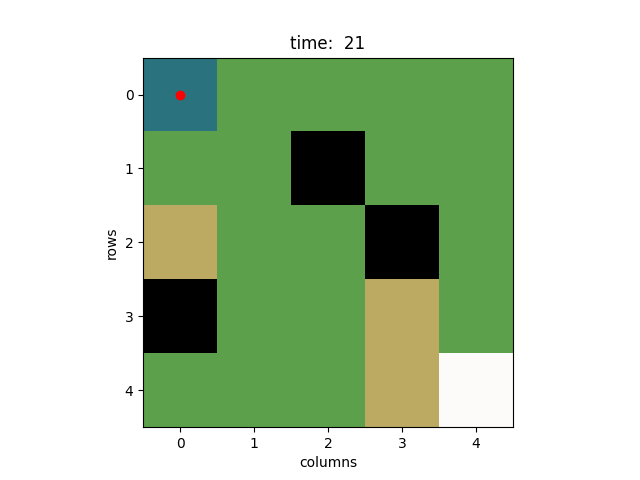

In [6]:
mygrid.reset()
s = mygrid.get_current_state()
done = False

while not done:
    action = np.random.randint(mygrid.Nactions)  # random action
    s_, r, done = mygrid.step(action)
    print("s: %3d  |  a: %1d  |  r: %3d  |  s_: %3d" % (s, action, r, s_))
    s = s_
    
mygrid.render()

### Questions

1. Play with the environment to create alternative maps
2. Implement a deterministic policy by imposing a sequence of actions

s:   0  |  a: 0  |  r:  -1  |  s_:   5
s:   5  |  a: 2  |  r:  -1  |  s_:   6
s:   6  |  a: 0  |  r:  -1  |  s_:  11
s:  11  |  a: 0  |  r:  -1  |  s_:  16
s:  16  |  a: 0  |  r:  -1  |  s_:  21
s:  21  |  a: 3  |  r:  -1  |  s_:  20


<IPython.core.display.Javascript object>


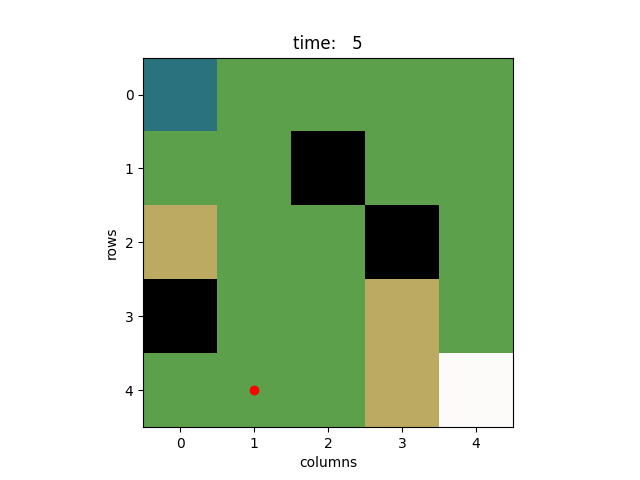

In [7]:
# Question 2
mygrid.reset()
s = mygrid.get_current_state()
done = False
action_sequence = [0, 2, 0, 0, 0, 3]  # 0 down; 1 up: 2 right; 3 left

for i in range(len(action_sequence)):
    action = action_sequence[i]  # random action
    s_, r, done = mygrid.step(action)
    print("s: %3d  |  a: %1d  |  r: %3d  |  s_: %3d" % (s, action, r, s_))
    s = s_
    
mygrid.render()

## The value iteration algorithm

The value iteration algorithm is used to evaluate the state-value $v_\pi(s)$ of a given policy $\pi(a|s)$. 

The steps of value iteration are the following:
- the values are initialized with $v_0(s)=0$ for all states $s$
- for all states, we update the value with an iterative procedure

$$v_{k+1}(s) = \sum_a \pi(a|s) \left(\mathcal{R}^a_s + \gamma \sum_{s'} \mathcal{P}^a_{ss'} v_k(s')\right)$$

- This iterative procedure is repeated until $\| v_{k+1} - v_{k}\|_\infty < \epsilon$

In our case, the iterative procedure can be simplified because we use a discount $\gamma = 1$ and because the transition are deterministic with $s' = T(s,a)$, such that

$$v_{k+1}(s) = \sum_a \pi(a|s) \left(\mathcal{R}^a_s + v_k(T(s,a))\right)$$

In [18]:
class ValueIteration():
    def __init__(self, env):
        self.Nstates = env.Nstates
        self.env = env
        self.reset()
        
    def reset(self):    
        self.values = np.zeros(self.Nstates)
        self.valuemap = [self._create_map()]

    def iterate(self, policy):
        new_values = np.zeros(self.Nstates)
        for s in range(self.Nstates):
            if not self.env.get_terminal(s):
                r = 0
                vk = 0
                for a in range(self.env.Nactions):
                    s_ = self.env.transition_matrix[s, a]
                    r += policy[s,a] * self.env.get_reward(s_)
                    vk += policy[s,a] * self.values[s_]
                new_values[s] = r + vk
        norm_inf = np.max(np.abs(new_values - self.values))
        self.values = new_values
        self.valuemap.append(self._create_map())
        return norm_inf  
            
    #__ rendering functions _____________________
    def render(self):
        self._init_render()
        self.anim = matplotlib.animation.FuncAnimation(
            self.fig, 
            self._animate,
            frames=len(self.valuemap),
            interval=500,
        )
        plt.show()
        
    def _create_map(self):
        mymap = np.zeros((self.env.N,self.env.N))
        for s in range(self.Nstates):
            mymap[tuple(self.env.get_coord(s))] = self.values[s]
        return mymap
        
    def _init_render(self):
        self.fig, self.ax = plt.subplots(1,1)
        self.mapdata = self.ax.imshow(
            self.valuemap[0], 
            vmin = -25,
            vmax = +10,
            cmap='gist_earth',
            animated=True
        )
        
        cbar = self.fig.colorbar(self.mapdata, ax=self.ax)
        cbar.set_label('value v(s)')
        self.ax.grid(False)
        self.ax.set_xlabel('columns')
        self.ax.set_ylabel('rows')
    
    def _animate(self,i):
        self.mapdata.set_array(self.valuemap[i])
        self.ax.set_title('iteration: %3d' % i)
            

The policy $\pi(a|s)$ is stored in the matrix **policy** of size **(mygrid.Nstates, mygrid.Nactions)**.

### Questions
1. Write a random policy using the matrix **policy**
2. Write a simple function to assess that the policy is a probability function
3. Write the Value Iteration algorithm using the class **ValueIteration**
4. Plot the evolution of the values with the function **render()**

In [19]:
# Question 1
random_policy = np.ones((mygrid.Nstates, mygrid.Nactions)) / mygrid.Nactions

In [ ]:
# Question 2
def check_policy(policy):
    # all components are positive
    # all rows should sum to 1
    return True_probability

In [36]:
# Question 3
# PARAMETERS
N = 5
GOALS = [
    [4, 4]
]
HOLES = [
    [3, 0],
    [2, 3],
    [1, 2],    
]
OBSTACLES = [
    [2, 0],
    [3, 3],    
    [4, 3],    
]

# Creation of the grid and rendering
mygrid = GridWorld(N, goals=GOALS, holes=HOLES, obstables=OBSTACLES)

myVI = ValueIteration(mygrid)
convergence = False
epsilon = 0.1

while not convergence:
    norm = myVI.iterate(random_policy)
    print(norm)
    if norm < epsilon:
        convergence = True
    

5.5
3.25
2.015625
1.65625
1.576171875
1.414794921875
1.3250732421875
1.198333740234375
1.1317863464355469
1.0599842071533203
0.9923627376556396
0.9259510636329651
0.8630953878164291
0.803116999566555
0.7465588552877307
0.6932043062988669
0.6431093660648912
0.5961315916501917
0.5521852678211872
0.5111307430752277
0.47283926449154023
0.4371680768515489
0.4039777883568121
0.37312745745837006
0.34447970413426177
0.3179001453934376
0.29325909777763215
0.2704317461053769
0.24929875068928453
0.22974638708781825
0.21166672017660204
0.1949576065173808
0.17952266061831068
0.16527114513306174
0.15211782675527985
0.139982795031532
0.128791260019689
0.11847333274277361
0.10896379607214612
0.10020186999818037
0.09213097552991911


<IPython.core.display.Javascript object>


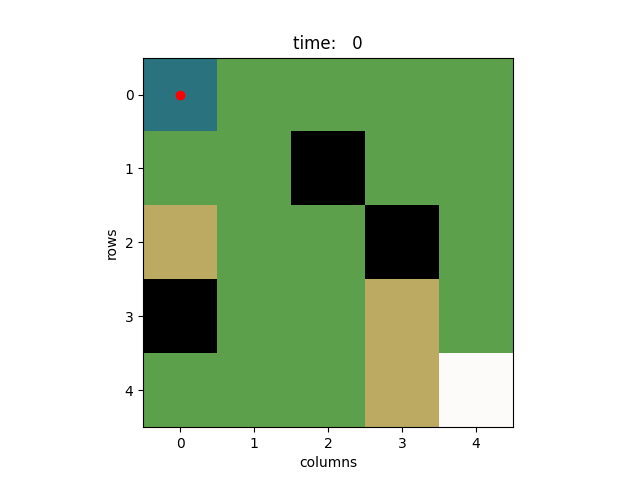

<IPython.core.display.Javascript object>


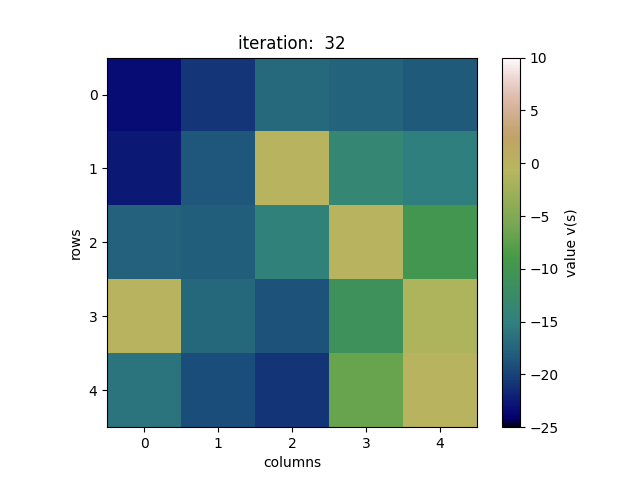

In [37]:
mygrid.render()
myVI.render()

## Policy iteration

From the approximation of $v_k \approx v_\pi(s)$, we can construct a greedy policy:

$$a = \pi(s) = \mathrm{argmax}_a \left[\mathcal{R}^a_s + \gamma \sum_{s'} \mathcal{P}^a_{ss'} v_k(s')\right]$$

which simplifies into 

$$a = \pi(s) = \mathrm{argmax}_a \left[\mathcal{R}^a_s + v_k(T(s,a))\right]$$


The value of this policy can then be estimated with value iteration. An so on...

### Questions
1. From the value matrix, construct the greedy policy matrix
2. Evaluate the value of this new policy
3. Iterate on value iteration and policy iteration to converge towards $v^*(s)$ and $\pi^*(s)$ (what is a good indication of convergence?)
4. Plot the motion of the agent using the policy $\pi^*(s)$

In [25]:
# Question 1
def build_greedy_policy(env, VI):
    policy = np.zeros((env.Nstates, env.Nactions))
    for s in range(env.Nstates):
        if env.get_terminal(s):
            policy[s, 0] = 1
        else:
            q = np.zeros(env.Nactions)
            for a in range(env.Nactions):
                s_ = env.transition_matrix[s, a]
                q[a] = env.get_reward(s_) + VI.values[s_]
            greedy_action = np.argmax(q)
            policy[s, greedy_action] = 1
    return policy   

<IPython.core.display.Javascript object>


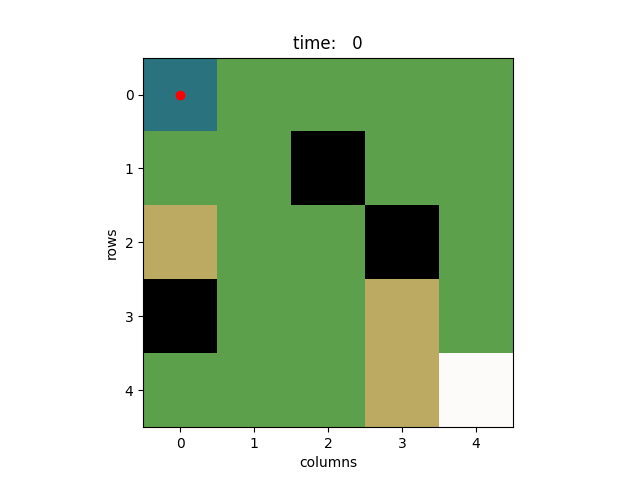

<IPython.core.display.Javascript object>


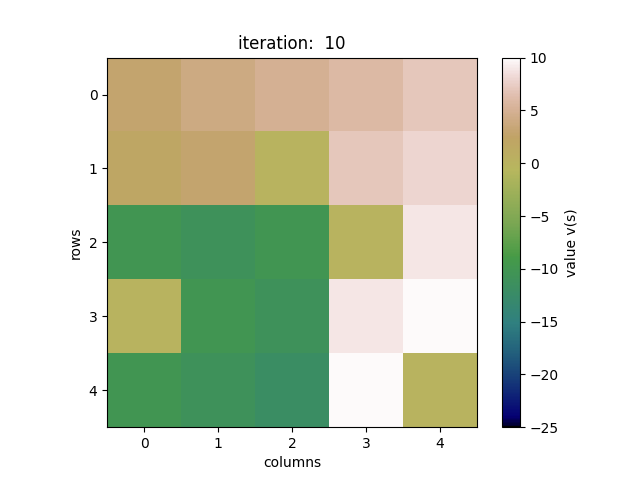

In [33]:
# Question 2
greedy_policy = build_greedy_policy(mygrid, myVI)

myVI.reset()
convergence = False
epsilon = 0.1

while not convergence:
    norm = myVI.iterate(greedy_policy)
    if norm < epsilon:
        convergence = True

mygrid.render()        
myVI.render()

In [ ]:
# Question 3
# outer loop (policy iteration loop)

In [ ]:
# Question 4
mygrid.reset()
s = mygrid.get_current_state()
done = False

while not done:
    action =   # greedy action using greedy policy
    s_, r, done = mygrid.step(action)
    print("s: %3d  |  a: %1d  |  r: %3d  |  s_: %3d" % (s, action, r, s_))
    s = s_
    
mygrid.render()

### Questions
1. What are the drawbacks of this method? 
2. How could it be improved? 